In [43]:
%matplotlib notebook

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
from sklearn import mixture
from IPython.display import display
from scipy.stats import multivariate_normal
import numpy as np
import math
import os
import GPy

# Simulating the enviormental phenonmena as a scaled mixture of Gaussians            
def rv(xvals, yvals):
    # Create mixture of Gaussian models
    C1 = [[10, 0], [0, 10]]
    C2 = [[24., 3], [0.8, 2.1]]
    C3 = [[3, 0], [0, 3]]
    m1 = [3, 8]
    m2 = [-5, -5]
    m3 = [5, -7]
    
    pos = np.empty(xvals.shape + (2,))
    pos[:, :, 0] = xvals
    pos[:, :, 1] = yvals

    val = 100. * ((1./3.) * 10.* multivariate_normal.pdf(pos, mean = m1, cov = C1) + \
            5. * (1./3.) * multivariate_normal.pdf(pos, mean = m2, cov = C2) + \
            5. * (1./3.) * multivariate_normal.pdf(pos, mean = m3, cov = C3))
    #return np.reshape(val, (val.shape[0] * val.shape[0], 1))
    return val

# Sensors have access to a noisy version of the true environmental distirbution          
def rv_sample(xvals, yvals):
    data = rv(xvals, yvals)
    return rv(xvals, yvals) + np.random.randn(xvals.shape[0], xvals.shape[1]) * 0.35

class GPModel:
    def __init__(self, xvals, zvals, lengthscale, variance, dimension = 2, noise = 0.05, kernel = 'rbf'):
        # The dimension of the evironment
        self.dim = dimension
        # The noise parameter of the sensor
        self.nosie = noise
        
        if kernel == 'rbf':
            self.kern = GPy.kern.RBF(input_dim = self.dim, lengthscale = lengthscale, variance = variance)
        else:
            raise ValueError('Kernel type must by \'rbf\'')
        
        # Read pre-trained kernel parameters from file, if avaliable
        if os.path.isfile('kernel_model.npy'):
            print "Loading kernel parameters from file"
            
            # Initialize GP model from file
            self.m = GPy.models.GPRegression(np.array(xvals), np.array(zvals), self.kern, initialize = False)
            self.m.update_model(False)
            self.m.initialize_parameter()
            self.m[:] = np.load('kernel_model.npy')
            self.m.update_model(True)
            
        else:
            print "Optimizing kernel parameters"
            # Initilaize GP model
            self.m = GPy.models.GPRegression(np.array(xvals), np.array(zvals), self.kern)
            self.m.initialize_parameter()

            # Constrain the hyperparameters during optmization
            self.m.constrain_positive('')
            self.m['rbf.variance'].constrain_bounded(0.01, 10)
            self.m['rbf.lengthscale'].constrain_bounded(0.01, 10)
            self.m['Gaussian_noise.variance'].constrain_fixed(noise)
            
            # Train the kernel hyperparameters
            self.m.optimize_restarts(num_restarts = 1, messages = True)
            
            # Save the hyperparemters to file
            np.save('kernel_model.npy', self.m.param_array)
            
        # Visualize the learned GP kernel
        def kernel_plot(self):
            _ = self.kern.plot()
            plt.ylim([-1, 1])
            plt.xlim([-1, 1])
            plt.show()

class Environment:
    def __init__(self, ranges,):
        # Expect ranges to be a 4-tuple consisting of xmin, xmax, ymin, and ymax
        self.xmin = float(ranges[0])
        self.xmax = float(ranges[1])
        self.ymin = float(ranges[2])
        self.ymax = float(ranges[3]) 
        
        self.rv = rv
        self.rv_noisy = rv_sample
        print "Environment onitialized with bounds X: (", self.xmin, ",", self.xmax, ")  Y:(", self.ymin, ",", self.ymax, ")" 
    
    # Generate data from a Gaussian mixture model            
    def initializeGP(self, ranges, training_points, visualize = True):
        # Sample inputs and outputs 2D data
        if visualize:
            np.random.seed(0)
            x = np.linspace(ranges[0], ranges[1], 100)
            y = np.linspace(ranges[2], ranges[3], 100)
            xvals, yvals = np.meshgrid(x, y, sparse = False, indexing = 'xy')
            zvals = rv(xvals, yvals)

        xtrain = np.linspace(ranges[0], ranges[1], training_points)
        ytrain = np.linspace(ranges[2], ranges[3], training_points)
        xtrain, ytrain= np.meshgrid(xtrain, ytrain, sparse = False, indexing = 'xy')
        data = np.vstack([xtrain.ravel(), ytrain.ravel()]).T
        ztrain = rv_sample(xtrain, ytrain)

        # Create and train parmeters of GP model
        self.GP = GPModel(data, np.reshape(ztrain, (data.shape[0], 1)), lengthscale = 10.0, variance = 0.5)            

        if visualize: 
            fig = plt.figure()
            ax = fig.add_subplot(211, projection = '3d')
            surf = ax.plot_surface(xvals, yvals, zvals, cmap = cm.coolwarm, linewidth = 0)

            ax2 = fig.add_subplot(212, projection = '3d')
            scatter = ax2.scatter(xtrain, ytrain, ztrain, c = ztrain, cmap = cm.coolwarm)
            plt.show()    
        
    # Return the reward of a set of points    
    def reward(point_set):
        print 'Compute reward using GP variance'
    
        
class Robot:
    def __init__(self, start_loc):
        self.start_loc = start_loc # Initial location of the robot
        self.delta = 0.30 # Sampling rate of the robot
        self.num_paths = 4 # Number of paths in the path set
        
    # Returns the list of the points along the path specified by <option>, starting at and including start_pt    
    def path_set(self, start_pt, option):
        assert(option < self.num_paths), 'Option must be in range 0 - %d'%self.num_paths
        assert(option >= 0), 'Option must be in range 0 - %d'%self.num_paths
        
        # Unpack the values of the start point
        x, y = start_pt
        if option == 0:
            locs = list([start_pt])
            for i in xrange(1, 4):
                new_loc = [x + i * self.delta, y]
                locs.append(new_loc)
            return np.array(locs)
        elif option == 1:
            locs = list([start_pt])
            for i in xrange(1, 4):
                new_loc = [x - i * self.delta, y]
                locs.append(new_loc)
            return np.array(locs)
        elif option == 2:
            locs = list([start_pt])
            for i in xrange(1, 4):
                new_loc = [x, y + i * self.delta]
                locs.append(new_loc)
            return np.array(locs)
        elif option == 3:
            locs = list([start_pt])
            for i in xrange(1, 4):
                new_loc = [x, y - i * self.delta]
                locs.append(new_loc)
            return np.array(locs)
            

    '''
    def path_right(start_pt):
        x, y 
        start_pt[0] += 1
        return np.array(start_pt)
    def path_left(start_pt):
        start_pt[0] -= 1
        return np.array(start_pt)
    def path_forward(start_pt):
        start_pt[1] += 1
        return np.array(start_pt)
    def path_backward(start_pt):
        locs = list([start_pt])
        locs.append()
        start_pt[1] -= 1
        return np.array([start_pt, new_loc])

    self.path_sets = [path_right, path_left, path_forward, path_backward]
    '''


        
def UBC_replanning(robot, world):
    print 'Planning a path through the world!'
    
    


Environment onitialized with bounds X: ( -10.0 , 10.0 )  Y:( -10.0 , 10.0 )
Loading kernel parameters from file


<IPython.core.display.Javascript object>


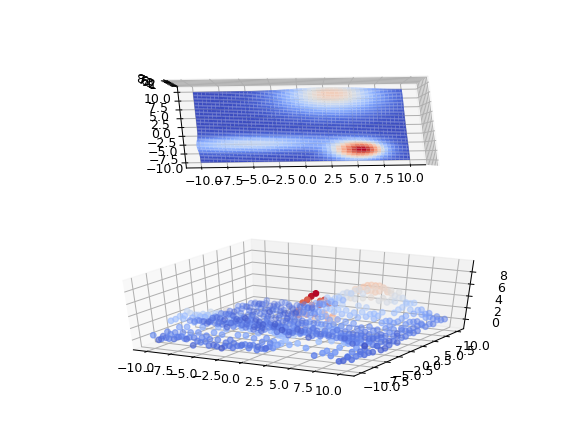

array([[ 0. ,  5. ],
       [ 0. ,  4.7],
       [ 0. ,  4.4],
       [ 0. ,  4.1]])

In [46]:
# Xmin, Xmax, Ymin, Ymax extent of the rectangular domain
ranges = (-10, 10, -10, 10)
# Number of points to train the GP with
training_points = 25

# Train the GP using a set number of noisy observations from underlying function
world = Environment(ranges)
world.initializeGP(ranges, training_points, visualize = True)

# Create the point robot
robot = Robot([0, 0])

robot.path_set([0,5], 3)